In [1]:
!pip install astra-toolbox
!pip install pyellipsoid

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 123.4 MB/s eta 0:00:00


In [2]:
from feldkamp import Feldkamp
import numpy as np
from create_dataset import get_data, to_tif, to_np
import os

In [3]:
num_projections = 11
tif_path = './dataset/tif/'
np_path = './dataset/np/'
dim = (100, 256, 256, 50)
#num_vols = 30

In [4]:
if not os.path.exists(np_path):
    os.makedirs(np_path)
if not os.path.exists(tif_path):
    os.makedirs(tif_path)
if not os.listdir(np_path):
    ellipsoid_data = get_data(dim)
    to_tif(ellipsoid_data, tif_path, type='xy')
    to_np(ellipsoid_data, np_path)

Drawing the  0 -th Ellipsoid........../............./......../........
Drawing the  1 -th Ellipsoid............./.........../...../...
Drawing the  2 -th Ellipsoid............./.........../....../............
Drawing the  3 -th Ellipsoid.........../........../...../......
Drawing the  4 -th Ellipsoid............/.........../......../.......
Drawing the  5 -th Ellipsoid........./.........../......../..
Drawing the  6 -th Ellipsoid............/.........../......./.
Drawing the  7 -th Ellipsoid............/........../......../............
Drawing the  8 -th Ellipsoid.........../............./......../..
Drawing the  9 -th Ellipsoid............./............/......../...........
Drawing the  10 -th Ellipsoid.........../............/......./....
Drawing the  11 -th Ellipsoid.........../........../......../......
Drawing the  12 -th Ellipsoid............./........./......./...
Drawing the  13 -th Ellipsoid............/........./...../.......
Drawing the  14 -th Ellipsoid............./.......

In [5]:
path = './dataset/tif/'
Feldkamp = Feldkamp(path)

Coordinate della sorgente ottenute:
         x          y          z
   -207.06    -128.00     797.74
   -166.33    -128.00     807.52
   -125.15    -128.00     815.15
    -83.62    -128.00     820.62
    -41.87    -128.00     823.90
      0.00    -128.00     825.00
     41.87    -128.00     823.90
     83.62    -128.00     820.62
    125.15    -128.00     815.15
    166.33    -128.00     807.52
    207.06    -128.00     797.74


In [6]:
Feldkamp.run(noise_levels=[0.00, 0.05])

Volume: ellipsoid_dataset_53_xy.tif, Rumore: 0.0:   0%|          | 0/200 [00:00<?, ?volume/s]
Proiezioni: (500, 11, 700):  67%|██████▋   | 2/3 [00:00<00:00,  8.65it/s]
                                                                         
Volume: (50, 256, 256), tempo: 0.29s:  67%|██████▋   | 2/3 [00:00<00:00,  5.67it/s]
Volume: ellipsoid_dataset_53_xy.tif, Rumore: 0.05:   0%|          | 1/200 [00:00<02:20,  1.42volume/s]
Rumore aggiunto: 0.05: 100%|██████████| 3/3 [00:00<00:00, 15.69it/s]
                                                                    
Volume: (50, 256, 256), tempo: 0.02s:  67%|██████▋   | 2/3 [00:00<00:00, 24.01it/s]
Volume: ellipsoid_dataset_92_xy.tif, Rumore: 0.0:   1%|          | 2/200 [00:01<01:39,  1.99volume/s] 
Proiezioni: (500, 11, 700):  67%|██████▋   | 2/3 [00:00<00:00, 136.52it/s]
                                                                          
Volume: (50, 256, 256), tempo: 0.02s:  67%|██████▋   | 2/3 [00:00<00:00, 19.98it/s]
Volume: elli


Riepilogo elaborazione:
- Volumi elaborati: 100
- Livelli di rumore: [0.0, 0.05]
- Totale ricostruzioni: 200
- Dimensione volumi: (50, 256, 256)
- Memoria utilizzata: 2500.00 MB


In [7]:
import numpy as np
import matplotlib.pyplot as plt


data = np.load('reconstructions.npz')


print("Chiavi disponibili nel file:", data.files)


volumes = data['volumes']
print("Shape dei volumi:", volumes.shape)

Chiavi disponibili nel file: ['volumes', 'volume_name', 'noise_level', 'metadata']
Shape dei volumi: (200, 50, 256, 256)


In [21]:
from metrics import *

data = np.load('reconstructions.npz')
ground_truth = np.load('dataset/np/ellipsoid_dataset.npy')

volume_name = data['volume_name']

def get_number(name):
  return int(name.split('_')[2])

sorted_data = np.argsort([get_number(name) for name in volume_name])
#sorted = volume_name[sorted_data]


volumes = data['volumes'][sorted_data]
noise_level = data['noise_level']

noised = np.where(noise_level == 0.00)[0]

reconstruction = volumes[noised]
ground_truth = np.transpose(ground_truth, (0, 3, 1, 2))
#reconstruction = np.transpose(reconstruction, (0, 2, 3, 1))

print(f'reconstruction shape: {reconstruction.shape}')
print(f'ground_truth shape: {ground_truth.shape}')


re = rel_err(ground_truth, reconstruction)
psnr = PSNR(ground_truth, reconstruction)
rmse = RMSE(ground_truth, reconstruction)
ssim = SSIM(ground_truth, reconstruction)

print(f're: {re}, psnr: {psnr}, rmse: {rmse}, ssim: {ssim}')

reconstruction shape: (100, 50, 256, 256)
ground_truth shape: (100, 50, 256, 256)
re: 0.8357880115509033, psnr: 10.986120516382503, rmse: 0.29107990860939026, ssim: 0.1599233891340305


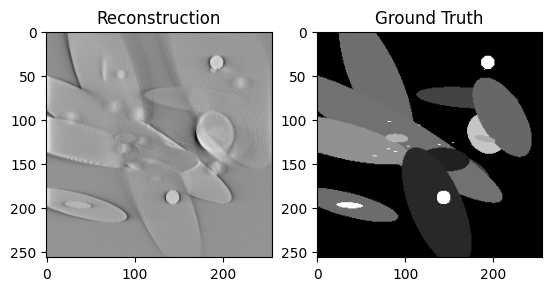

In [22]:
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1); plt.imshow(reconstruction[0, 10], cmap='grey'); plt.title("Reconstruction")
plt.subplot(1, 2, 2); plt.imshow(ground_truth[0, 10], cmap='grey'); plt.title("Ground Truth")
plt.show()

In [23]:
import torch
from sklearn.model_selection import train_test_split

def normalize(vol):
  return (vol - vol.min()) / (vol.max() - vol.min())

reconstruction = np.array([normalize(vol) for vol in reconstruction])
ground_truth = np.array([normalize(vol) for vol in ground_truth])

train_reconstruction, test_reconstruction, train_ground_truth, test_ground_truth = train_test_split(reconstruction, ground_truth, test_size=0.2, random_state=42)

train_reconstruction = torch.FloatTensor(train_reconstruction).unsqueeze(1)  # [N, 1, D, H, W]
train_ground_truth = torch.FloatTensor(train_ground_truth).unsqueeze(1)
test_reconstruction = torch.FloatTensor(test_reconstruction).unsqueeze(1)
test_ground_truth = torch.FloatTensor(test_ground_truth).unsqueeze(1)

print(f'train_reconstruction shape: {train_reconstruction.shape}')
print(f'test_reconstruction shape: {test_reconstruction.shape}')
print(f'train_ground_truth shape: {train_ground_truth.shape}')
print(f'test_ground_truth shape: {test_ground_truth.shape}')


train_reconstruction shape: torch.Size([80, 1, 50, 256, 256])
test_reconstruction shape: torch.Size([20, 1, 50, 256, 256])
train_ground_truth shape: torch.Size([80, 1, 50, 256, 256])
test_ground_truth shape: torch.Size([20, 1, 50, 256, 256])


In [24]:
from torch import nn
from torch.nn import functional as F
import torch # Ensure torch is imported if not already

class ResidualBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # The first convolution might change channel dimensions if in_channels != out_channels
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        # The second convolution maintains channel dimensions
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)

        # Add a 1x1 convolution for residual connection if input and output channels differ
        self.residual_conv = None
        if in_channels != out_channels:
            self.residual_conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)


    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # Apply residual convolution if necessary
        if self.residual_conv:
            residual = self.residual_conv(residual)

        out += residual
        return F.relu(out)

class ResUnet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        # Encoder
        # Output channels: 64
        self.enc1 = nn.Sequential(
            nn.Conv3d(in_channels, 64, kernel_size=3, padding=1),
            ResidualBlock3D(64, 64)
        )
        # Output channels: 128
        self.enc2 = nn.Sequential(
            nn.MaxPool3d(2),
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            ResidualBlock3D(128, 128)
        )
        # Bottleneck
        # Output channels: 256
        self.bottleneck = nn.Sequential(
            nn.MaxPool3d(2),
            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            ResidualBlock3D(256, 256)
        )
        # Decoder
        # Upconvolution brings channels from 256 to 128
        self.up1 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2, output_padding=1)
        # After concat with e2 (128 channels), input to dec1 is 128 + 128 = 256 channels
        # Residual block reduces channels from 256 to 128
        self.dec1 = ResidualBlock3D(256, 128)

        # Upconvolution brings channels from 128 to 64
        self.up2 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2, output_padding=1)
        # After concat with e1 (64 channels), input to dec2 is 128 + 64 = 192 channels
        # Residual block reduces channels from 192 to 64
        # FIX: The input to dec2 is d2 concatenated with e1. up2 outputs 64 channels, e1 outputs 64 channels.
        # The concatenation results in 64 + 64 = 128 channels, not 192.
        self.dec2 = ResidualBlock3D(128, 64) # Changed from 192 to 128

        # Output layer reduces channels from 64 to out_channels
        self.out = nn.Conv3d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        b = self.bottleneck(e2)
        d1 = self.up1(b)

        # Crop d1 to match the spatial dimensions of e2
        # e2 spatial shape: (Depth, Height, Width)
        # d1 spatial shape: (Depth, Height+1, Width+1) due to output_padding=1 on Height/Width
        # We need to crop 1 pixel from the end of Height and Width dimensions of d1
        depth_e2, height_e2, width_e2 = e2.shape[-3:]
        d1 = d1[:, :, :depth_e2, :height_e2, :width_e2] # Crop depth, height, and width to match e2

        # Concatenate d1 and e2 along the channel dimension (dim=1)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec1(d1)

        d2 = self.up2(d1)

        # Crop d2 to match the spatial dimensions of e1
        # Based on the structure, d2 should match e1's spatial dimensions
        depth_e1, height_e1, width_e1 = e1.shape[-3:]
        d2 = d2[:, :, :depth_e1, :height_e1, :width_e1] # Crop depth, height, and width to match e1

        # Concatenate d2 and e1 along the channel dimension (dim=1)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec2(d2)

        return torch.sigmoid(self.out(d2))

# Re-instantiate the model with the corrected forward pass
model = ResUnet3D()

In [25]:
class Loss(nn.Module):
  def __init__(self):
    super(Loss, self).__init__()

  def forward(self, pred, target):
    pred_cpu = pred.cpu().detach().numpy()
    target_cpu = target.cpu().detach().numpy()
    rmse_loss = RMSE(pred, target)
    rel_err = rel_err(pred, target)
    psnr_val = PSNR(pred, target)
    ssim_val = SSIM(pred, target)

    ssim = 1 - ssim_val
    psnr = 1 / (psnr_val + 1e-8)

    return rmse_loss + rel_err + ssim + psnr

In [26]:
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

train_dataset = TensorDataset(train_reconstruction, train_ground_truth)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_dataset = TensorDataset(test_reconstruction, test_ground_truth)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

criterion = Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(20):
    # Training
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()

    print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(test_loader):.4f}")

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.61 GiB. GPU 0 has a total capacity of 39.56 GiB of which 896.88 MiB is free. Process 17718 has 38.67 GiB memory in use. Of the allocated memory 36.24 GiB is allocated by PyTorch, and 1.94 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
model.eval()
with torch.no_grad():
    outputs = []
    for input in test_reconstruction:
        input = input.unsqueeze(0).to(device)
        output = model(input)
        outputs.append(output.squeeze().cpu().numpy())

outputs = np.array(outputs)

psnr = PSNR(ground_truth, outputs)
print(f'PSNR: {psnr}')


In [ ]:
model.eval()
with torch.no_grad():
    # Select a test volume
    test_input = test_reconstruction[0:1].to(device)
    test_output = model(test_input)
    test_target = test_ground_truth[0:1].to(device)

    # Convert to numpy
    input_slice = test_input.squeeze().cpu().numpy()[25]  # Middle slice (D/2)
    output_slice = test_output.squeeze().cpu().numpy()[25]
    target_slice = test_target.squeeze().cpu().numpy()[25]

    # Compute metrics
    from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
    #p = psnr(target_slice, output_slice, data_range=1.0)
    ssim = ssim(target_slice, output_slice, data_range=1.0)

    psnr = PSNR(target_slice, output_slice)
    #ssim = SSIM(target_slice, output_slice)

    print(f"PSNR: {psnr:.2f} dB, SSIM: {ssim:.4f}")

    # Plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(input_slice, cmap='gray')
    plt.title("Noisy Input")
    plt.subplot(1, 3, 2)
    plt.imshow(output_slice, cmap='gray')
    plt.title("Denoised Output")
    plt.subplot(1, 3, 3)
    plt.imshow(target_slice, cmap='gray')
    plt.title("Ground Truth")
    plt.show()